In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import string
import re
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
recs = pd.read_csv('cleaned_recs.csv')[['Document File Name ', 'Recommendation text']].dropna(0, 'all')
# df = df[['Recommendation text']].dropna().reset_index(drop = True)
file_mapping = pd.read_csv("file_mapping.csv")

In [4]:
merged = pd.merge(recs, file_mapping, left_on="Document File Name ", right_on="original_name", how='inner')

In [5]:
merged.columns

Index(['Document File Name ', 'Recommendation text', 'original_name',
       'indexed_name'],
      dtype='object')

In [6]:
test = merged.loc[(merged.indexed_name == '12.pdf') | (merged.indexed_name == '9.pdf')]
train = merged.loc[~((merged.indexed_name == '12.pdf') | (merged.indexed_name == '9.pdf'))]

In [7]:
train.shape[0], test.shape[0]

(100, 9)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
stopwords = nltk.corpus.stopwords.words('english')

def plot_top_ngrams_barchart(text, n):
    stop=set(stopwords)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

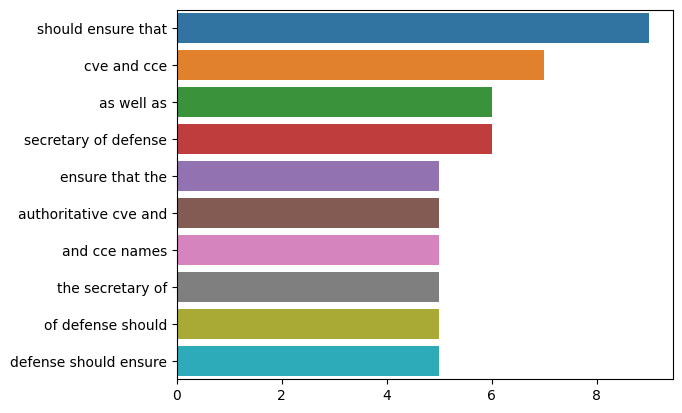

In [10]:
plot_top_ngrams_barchart(merged['Recommendation text'], n=3)

In [11]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models as gensim
import pyLDAvis
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

def get_lda_objects(text):   
    stop=set(nltk.corpus.stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [12]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/shubham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shubham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/shubham/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
lda_model, bow_corpus, dic = get_lda_objects(merged['Recommendation text'])

In [14]:
lda_model.show_topics()

[(0,
  '0.023*"vulnerability" + 0.021*"CVE" + 0.021*"name" + 0.015*"CCE" + 0.014*"product" + 0.012*"system" + 0.009*"service" + 0.008*"CPE" + 0.008*"software" + 0.008*"must"'),
 (1,
  '0.020*"sector" + 0.010*"industry" + 0.010*"plan" + 0.010*"private" + 0.009*"input" + 0.008*"government" + 0.008*"The" + 0.007*"response" + 0.006*"information" + 0.006*"Framework"'),
 (2,
  '0.016*"cybersecurity" + 0.012*"ensure" + 0.007*"Federal" + 0.007*"technology" + 0.007*"input" + 0.007*"The" + 0.006*"security" + 0.006*"validated" + 0.006*"state" + 0.006*"agency"'),
 (3,
  '0.015*"cyber" + 0.013*"The" + 0.008*"strategy" + 0.008*"including" + 0.008*"DOD" + 0.007*"ensure" + 0.007*"U.S." + 0.007*"development" + 0.007*"acquisition" + 0.007*"component"')]

In [15]:
pyLDAvis.enable_notebook()
vis = gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.113819  0.084564       1        1  31.309241
1      0.127871  0.069776       2        1  26.498726
3     -0.000380 -0.105884       3        1  22.371539
2     -0.013672 -0.048456       4        1  19.820495, topic_info=              Term       Freq      Total Category  logprob  loglift
437         sector  10.000000  10.000000  Default  30.0000  30.0000
16   vulnerability  14.000000  14.000000  Default  29.0000  29.0000
1              CVE  12.000000  12.000000  Default  28.0000  28.0000
8             name  13.000000  13.000000  Default  27.0000  27.0000
0              CCE   9.000000   9.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
338     government   1.605218   7.154947   Topic4  -5.3966   0.1239
19           apply   1.410878   4.699954   Topic4  -5.5256   0.4151
83            used   1.405174   5.909447   Topic4  -5.5297   0.1821
67       necessary   1.357306   3.246586   Topic4  -5.5643   0.7464
8             name   1.356462  13.258620   Topic4  -5.5650  -0.6613

[239 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
296       3  0.515977   Acquisitions
248       4  0.537153       Agencies
86        2  0.524258            All
86        4  0.524258            All
684       3  0.515976      Awareness
...     ...       ...            ...
16        2  0.070771  vulnerability
189       3  0.515975            web
47        1  0.632104           well
47        3  0.210701           well
47        4  0.210701           well

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [16]:
# WHO NEEDS WORDCLOUDS ANYWAY

# from wordcloud import WordCloud

# def plot_wordcloud(text):
#     stop=set(nltk.corpus.stopwords.words('english'))

#     def _preprocess_text(text):
#         corpus=''
#         stem=PorterStemmer()
#         lem=WordNetLemmatizer()
#         for news in text:
#             words=[w for w in word_tokenize(news) if (w not in stop)]

#             words=[lem.lemmatize(w) for w in words if len(w)>2]

#             corpus += ' '.join(words)
#         return corpus
    
#     corpus=_preprocess_text(text)
    
#     wordcloud = WordCloud(
#         background_color='salmon', colormap='Pastel1',
#         stopwords=stop,
#         max_words=100,
#         max_font_size=30, 
#         scale=3,
#         random_state=1)
    
#     wordcloud=wordcloud.generate(corpus)

#     fig = plt.figure(1, figsize=(20, 15))
#     plt.axis('off')
 
#     plt.imshow(wordcloud)
#     plt.show()

# plot_wordcloud(df['Recommendation text'])

## Sentence embeddings

In [17]:
import seaborn as sns
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [18]:
sentences = train['Recommendation text'].to_numpy()
sentence_embeddings = sbert_model.encode(sentences)

In [19]:
sentence_embeddings.shape

(100, 768)

### Cosine Similarity

In [20]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

matrix = np.identity(sentence_embeddings.shape[0])
for i in range(matrix.shape[0]):
  for j in range(i,matrix.shape[0]):
    matrix[i][j] = cosine(sentence_embeddings[i],sentence_embeddings[j])
    matrix[j][i] = matrix[i][j]

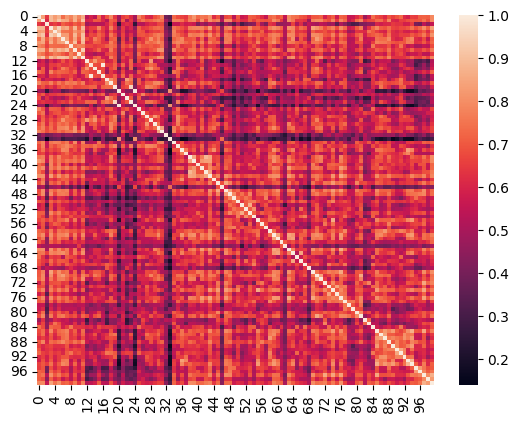

In [21]:
ax = sns.heatmap(matrix)

In [22]:
recomm = np.mean(sentence_embeddings,axis=0)

In [23]:
from tika import parser

raw12 = parser.from_file('12.pdf')
raw9 = parser.from_file('9.pdf')

In [24]:
text12 = raw12['content'].replace('\n','')
text9 = raw9['content'].replace('\n','')

text = text12 + ' ' + text9
sentences = nltk.sent_tokenize(text)

In [25]:
relevant = []
distances = []

for sentence in sentences:
  embedd = sbert_model.encode(sentence)
  distances.append(cosine(recomm, embedd))

In [26]:
sorted_idx = sorted(range(len(distances)), key=lambda k: distances[k], reverse=True)
sorted_sentences = np.array(sentences)[sorted_idx]

In [27]:
sorted_distances = sorted(distances, reverse=True)

preds = pd.DataFrame(list(zip(sorted_sentences, sorted_distances)), columns=['Sentence', 'Cosine'])

In [31]:
preds

,Sentence,Cosine
0,Federal departments and agencies should give s...,0.917207
1,While CVE compatibility should be an important...,0.908419
2,Assured Decisionmaking Procedures for Cyber Op...,0.890087
3,Your organization’s use of CVE-compatible prod...,0.882318
4,Agencies should identify the CVE entries that ...,0.881533
...,...,...
751,There is no apparent effort to build mutual tr...,0.217219
752,2.,0.209885
753,2.,0.209885
754,2.,0.209885


In [28]:
import difflib

def retrieve_sentence_index(sentence, sentence_list):
    # Tokenize the sentences
    sentence_tokens = sentence.split()
    sentence_list_tokens = [s.split() for s in sentence_list]
    
    # Calculate the similarity between the sentences
    similarity_scores = [difflib.SequenceMatcher(None, sentence_tokens, s).ratio() for s in sentence_list_tokens]
    
    # Find the index of the most similar sentence
    max_similarity_index = similarity_scores.index(max(similarity_scores))
    
    # Check if the retrieved sentence contains the original sentence
    # retrieved_sentence = sentence_list[max_similarity_index]
    # if sentence in retrieved_sentence:
    #     return max_similarity_index
    # else:
    #     return None
    return max_similarity_index

In [32]:
test_indices = [retrieve_sentence_index(sentence, preds['Sentence']) for sentence in test.iloc[:, 1]]
test_preds = preds.iloc[test_indices, :]
final = test_preds.set_index(100 * test_preds.index/len(preds)).sort_index()

In [33]:
final

,Sentence,Cosine
0.529101,Agencies should identify the CVE entries that ...,0.881533
1.058201,Domestic and foreign policy oversight by compe...,0.862859
2.248677,Federal departments and agencies should period...,0.830548
2.777778,3http://cve.mitre.org/http://icat.nist.gov/htt...,0.826420
5.555556,"Intelligence oversight, including an “intellig...",0.791437
6.349206,Since it is infeasible for an organization to ...,0.784882
9.788360,Such oversight also should provide assess-ment...,0.757797
10.582011,Technical oversight that includes a “technical...,0.749276
23.677249,Operational oversight with appropriate respons...,0.689108


In [34]:
final.Cosine.mean()

0.7970957159996033

In [35]:
test.iloc[:, [1, 3]]

,Recommendation text,indexed_name
36,Federal departments and agencies should period...,12.pdf
37,NIST recommends monitoring systems for vulnera...,12.pdf
38,Agencies should identify the CVE entries that ...,12.pdf
39,Since it is infeasible for an organization to ...,12.pdf
101,Domestic and foreign policy oversight by compe...,9.pdf
102,Technical oversight that includes a “technical...,9.pdf
103,Such oversight also should provide assess- men...,9.pdf
104,Operational oversight with appropriate respons...,9.pdf
105,"Intelligence oversight, including an “intellig...",9.pdf


In [38]:
for i in range(25):
    print(preds.iloc[i, 0])
    print("")

Federal departments and agencies should give substantial consideration to the acquisition and use of security-related IT products and services that are compatible with the CVE vulnerability naming scheme.

While CVE compatibility should be an important consideration in IT security product and service acquisition, federal departments and agencies should foremost consider their overall requirements (functionality, cost, performance, architecture, etc.)

Assured Decisionmaking Procedures for Cyber OperationsTo reduce risks of ill-conceived cyber operations, the two sides should subject all such operations to robust oversight and risk management protocols.

Your organization’s use of CVE-compatible products can assist you by  1) determining which product covers the vulnerabilities most applicable to an agency’s network infrastructure; and   2) increasing the assurance that the alerts produced by the product(s) you choose will be able to be correlated with alerts from your other products an

### Potential Future Steps:

1. Choose any BERT model (RoBERTa?).
2. Get embeddings for modal verbs.
3. Use them to extract general recommendations.
4. Train a recommendation classifier (cyber/non-cyber).
5. Steps 3-4 allow for evalutions to be more systematic.

In [37]:
def extract_modal_sentences(corpus):
    modal_verbs = ["can", "could", "may", "might", "must", "shall", "should", "will", "would"]
    modal_sentences = []
    for sentence in corpus:
        for word in sentence:
            if word.lower() in modal_verbs:
                modal_sentences.append(sentence)
                break
    return modal_sentences